In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet.keras as efn 
import librosa
import librosa.display as display
import os
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from sklearn.utils import class_weight
import warnings
from tqdm import tqdm
#from tensorflow.keras import backend

from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise
from kapre.time_frequency import Spectrogram

%matplotlib inline

#!rm -r train_data
#!rm -r val_data
#!rm -r models
#!mkdir models

# suppress warnings
warnings.filterwarnings("ignore")

SOUND_DIR = "/project/data/birdsong-recognition/train_audio/"

Using TensorFlow backend.


In [2]:
# function to plot signal
def plot_signal(input_path, fileName, target_audio_length=5):
    
    signal, sr = librosa.load(os.path.join(input_path, fileName), duration=12, sr=16000)
    
    signal = filter_signal(signal, sr, target_audio_length)
    
    plt.plot(list(signal))
    plt.show()
    
    print(np.max(signal))
    
def filter_signal(signal, sr, target_audio_length):

    signal_max = np.max(signal)
    frame_max = list(signal).index(signal_max)
    
    if len(signal) <= sr * target_audio_length:
        return signal
    elif frame_max + sr * target_audio_length / 2 > len(signal):
        return signal[-sr*target_audio_length:]
    elif frame_max - sr * target_audio_length / 2 < 0:
        return signal[:sr*target_audio_length]
    else:
        return signal[int(frame_max-sr*target_audio_length/2):
                      int(frame_max+sr*target_audio_length/2)]
    
def filter_signal2(signal):
    
    if signal.shape[1] <= 224:
        return signal
    
    max_energy = np.sum(signal[0:224,0:224])
    signal_max = signal[0:224,0:224]
    for i in range(signal.shape[1]-224):
        tmp = np.sum(signal[0:224, i:i+224])
        if tmp > max_energy:
            max_energy = tmp
            signal_max = signal[0:224, i:i+224]
            
    return signal_max
        
# function for creating Mel Spectrogram
def createMelSpectrogram(input_path, fileName, output_path, saveOrShow=0, target_audio_length=5):
    
    # load sound signal
    signal, sr = librosa.load(os.path.join(input_path, fileName), duration=10, sr=16000)
    
    #signal = filter_signal(signal, sr, target_audio_length)
    
    # create Mel Spectrogram
    S = Melspectrogram(n_dft=1024, 
                       n_hop=256,
                       #n_hop=256,
                       input_shape=(1, signal.shape[0]),
                       padding='same', sr=sr, n_mels=224, fmin=1400, fmax=sr/2,
                       power_melgram=2.0, return_decibel_melgram=True,
                       trainable_fb=False, trainable_kernel=False)(signal.reshape(1, 1, -1)).numpy()
    
    S = S.reshape(S.shape[1], S.shape[2])
    
    S = filter_signal2(S)
    
    if saveOrShow == 0:   
        matplotlib.image.imsave(os.path.join(output_path, fileName.split(".")[0] + ".png"), S)
    else:
        #plt.imshow(S)
        #plt.show()
        display.specshow(S, sr=sr)
        plt.show()

## Visualizing Mel-Spectrogram of an audio

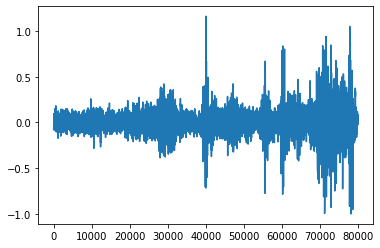

1.1646073


In [5]:
plot_signal(SOUND_DIR+"amtspa", "XC16891.mp3", 5)

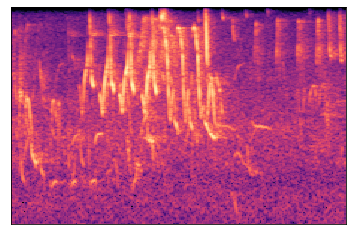

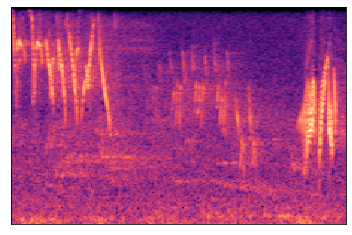

In [6]:
# bird: aldfly
createMelSpectrogram(SOUND_DIR+"aldfly", "XC134874.mp3", "", 1)
createMelSpectrogram(SOUND_DIR+"aldfly", "XC16967.mp3", "", 1)

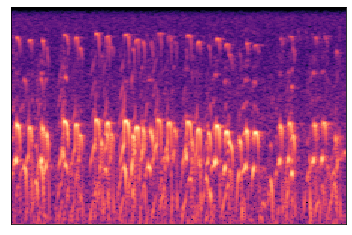

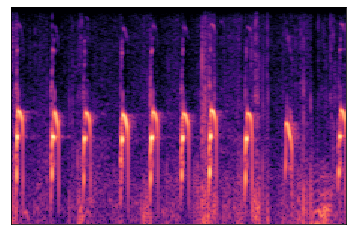

In [7]:
# bird: ameavo
createMelSpectrogram(SOUND_DIR+"ameavo", "XC133080.mp3", "", 1)
createMelSpectrogram(SOUND_DIR+"ameavo", "XC139829.mp3", "", 1)

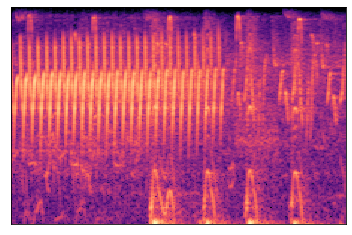

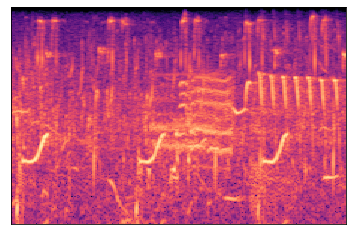

In [8]:
# amebit
createMelSpectrogram(SOUND_DIR+"amebit", "XC141316.mp3", "", 1)
createMelSpectrogram(SOUND_DIR+"amebit", "XC184876.mp3", "", 1)

## Create Mel-Spectrogram for training

In [5]:
BIRDS = ["amered", "annhum", "belkin1", "blugrb1", "brthum", 
         "cedwax", "commer", "gockin", "gryfly", "horlar", 
         "moudov", "olsfly", "pasfly", "semsan", "sposan", 
         "vigswa", "wewpew", "whbnut", "wilsni1", "yelwar"]

train_folder = "melspectrogram/Augmentation_isaac/train_data_isaac_20"
val_folder = "melspectrogram/Augmentation_isaac/val_data_isaac_20"

#if not os.path.exists(train_folder): os.mkdir(train_folder)
#if not os.path.exists(val_folder): os.mkdir(val_folder)

In [6]:
### This takes long time to run ###

# create train and val spectrogram
np.random.seed(1234)
for bird in tqdm(BIRDS):
    INPUT_DIR = os.path.join("data/birdsong-recognition/train_audio/", bird)
    TRAIN_DIR = os.path.join(train_folder, bird)
    VAL_DIR = os.path.join(val_folder, bird)
    
    # create folders
    if not(os.path.exists(TRAIN_DIR)) and not(os.path.exists(VAL_DIR)): 
        
        os.mkdir(TRAIN_DIR)
        os.mkdir(VAL_DIR)

        # split into train and val set
        for f in os.listdir(INPUT_DIR):
            rand = np.random.randint(0, 10)
            if f[0] != ".":
                if rand <= 7: 
                    createMelSpectrogram(INPUT_DIR, f, TRAIN_DIR)
                else:
                    createMelSpectrogram(INPUT_DIR, f, VAL_DIR)        

100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


In [7]:
IM_SIZE = (224,224,3,)
BATCH_SIZE = 32

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function=None,
                                   rescale=1/255)#,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #shear_range=0.2,
                                   #zoom_range=0.1,
                                   #fill_mode='nearest')

train_batches = train_datagen.flow_from_directory(train_folder,
                                                  classes=BIRDS, 
                                                  target_size=IM_SIZE[0:2], 
                                                  class_mode='categorical', 
                                                  shuffle=True, batch_size=BATCH_SIZE)

val_datagen = ImageDataGenerator(preprocessing_function=None, rescale=1/255)

val_batches = val_datagen.flow_from_directory(val_folder,
                                                  classes=BIRDS, 
                                                  target_size=IM_SIZE[0:2], 
                                                  class_mode='categorical', 
                                                  shuffle=False, batch_size=BATCH_SIZE)

class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(train_batches.classes), 
                                                  train_batches.classes)

Found 14138 images belonging to 20 classes.
Found 1941 images belonging to 20 classes.


In [9]:
input_layer = tf.keras.Input(shape=IM_SIZE)

convNet1 = efn.EfficientNetB3(include_top=False, 
                              weights="imagenet", 
                              input_tensor=None, 
                              input_shape=IM_SIZE)(input_layer)

#convNet2 = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', 
#                                                          include_top=False, 
#                                                          input_tensor=None, 
#                                                          input_shape=IM_SIZE)(input_layer)

#x1 = convNet1.output
#x2 = convNet2.output

#x1 = tf.keras.layers.GlobalAveragePooling2D()(convNet1)
#x2 = tf.keras.layers.GlobalMaxPooling2D()(convNet1)
#x = tf.keras.layers.Concatenate(axis=1)([x1, x2])

x = tf.keras.layers.GlobalAveragePooling2D()(convNet1)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)

output_layer = tf.keras.layers.Dense(len(BIRDS), activation='softmax', name='softmax')(x)
#net_final = tf.keras.Model(inputs=net.input, outputs=output_layer)
net_final = tf.keras.Model(inputs=input_layer, outputs=output_layer)

net_final.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='categorical_crossentropy', metrics=['accuracy'])

44113920/44107200 [==============================] - 6s 0us/step


In [10]:
net_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
softmax (Dense)              (None, 20)                30740     
Total params: 10,814,268
Trainable params: 10,726,972
Non-trainable params: 87,296
____________________________________________

In [11]:
ModelCheck = tf.keras.callbacks.ModelCheckpoint('models/efficientnet_checkpoint_5s.h5', monitor='val_loss', 
                                                verbose=0, 
                                                save_best_only=True, 
                                                save_weights_only=True, 
                                                mode='auto')

ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0)

net_final.reset_states()
net_final.fit_generator(train_batches, 
                        validation_data=val_batches,
                        steps_per_epoch = int(len(train_batches.classes)/BATCH_SIZE)+1,
                        validation_steps=(len(val_batches.classes)//BATCH_SIZE) + 1,
                        epochs=50, 
                        callbacks=[ModelCheck, ES],
                       class_weight={i:class_weights[i] for i in range(len(BIRDS))})

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
442/442 [==============================] - 524s 1s/step - loss: 1.3256 - accuracy: 0.6159 - val_loss: 1.3328 - val_accuracy: 0.6929
Epoch 2/50
442/442 [==============================] - 532s 1s/step - loss: 0.7324 - accuracy: 0.7875 - val_loss: 1.3325 - val_accuracy: 0.7290
Epoch 3/50
442/442 [==============================] - 527s 1s/step - loss: 0.5469 - accuracy: 0.8353 - val_loss: 0.9360 - val_accuracy: 0.7816
Epoch 4/50
442/442 [==============================] - 525s 1s/step - loss: 0.4440 - accuracy: 0.8643 - val_loss: 0.9254 - val_accuracy: 0.7924
Epoch 5/50
442/442 [==============================] - 536s 1s/step - loss: 0.3876 - accuracy: 0.8805 - val_loss: 1.0096 - val_accuracy: 0.7589
Epoch 6/50
442/442 [==============================] - 551s 1s/step - loss: 0.3122 - accuracy: 0.9032 - val_loss: 1.2215 - val_accuracy: 0.7666
Epoch 7/50
442/442 [==============================] - 527s 1s/step

In [12]:
net_final.load_weights('models/efficientnet_checkpoint_5s.h5')
print("Accuracy on val data")
net_final.evaluate(val_batches, steps=(len(val_batches.classes) // BATCH_SIZE)+1)[1]

Accuracy on val data
61/61 [==============================] - 63s 1s/step - loss: 0.9254 - accuracy: 0.7924


0.7923750877380371